In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer 
from sklearn.impute import MissingIndicator
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from src.utils import mape
from src.utils import zip_dataframes
from src.utils import unzip_dataframes
from src.utils import create_submit_df
from src.train import cross_validate
from src.train import full_tain_pred
from src.train import preprocessing
from src.preprocessing import *

## Data loading

In [2]:
data_folder = Path("data")
submissions_folder = Path("submissions")

train_df = pd.read_csv(data_folder / "train.csv", index_col=0)
test_df = pd.read_csv(data_folder / "test_no_target.csv", index_col=0)
zipcodes_df = pd.read_csv(data_folder / "zipcodes.csv", index_col=0)

train_df = pd.merge(train_df.reset_index(), zipcodes_df.drop_duplicates("zipcode"), on="zipcode", how="left")
test_df = pd.merge(test_df.reset_index(), zipcodes_df.drop_duplicates("zipcode"), on="zipcode", how="left")

## Cross-validation predict

In [3]:
# model = XGBRegressor(
#     random_state=42,
#     n_estimators=500,
#     max_depth=5,
#     objective="reg:gamma"
# )

# model = CatBoostRegressor(
#     random_state=42,
#     depth=10,
#     loss_function="MAE",
#     cat_features=[1, 3, 5, 7, 8, 12],
#     verbose=False,
# )

In [4]:
model = LGBMRegressor(
    random_state=42,
#     boosting="dart",
#     objective='regression_l1',
    objective='mape',
    num_leaves=100,
    feature_fraction=0.9,
    max_depth=-1,
    learning_rate=0.03,
    num_iterations=1300,
    subsample=0.5,
)

kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
preproc_funcs = [
    indicate_missing,
    impute_nan_with_zero,
    drop_columns,
#     drop_price_outliers,
    cat_encode,
]

val_scores, test_preds = cross_validate(
    model, 
    train_df,
    kfold,
    mape,
    preproc_funcs,
    test_df=test_df,
    log_target=True,
)

fold 1 score: 22.630212321737638
fold 2 score: 22.883187143732364
fold 3 score: 21.838743499291542
fold 4 score: 23.238107728160116
mean score: 22.647562673230414
score variance: 0.2646879609573328


In [5]:
submit_df = create_submit_df(test_df, np.mean(test_preds, axis=0))
submit_df.to_csv(submissions_folder / "lgbm-logtarget-stratkfold.csv", index=False)
submit_df

,Id,Predicted
0,60314,11055.729322
1,12566,10930.803264
2,17760,7208.192191
3,8876,886.556744
4,80392,6874.174200
...,...,...
49995,93878,1474.885184
49996,99783,3460.609972
49997,57399,1795.324888
49998,97106,11080.483846


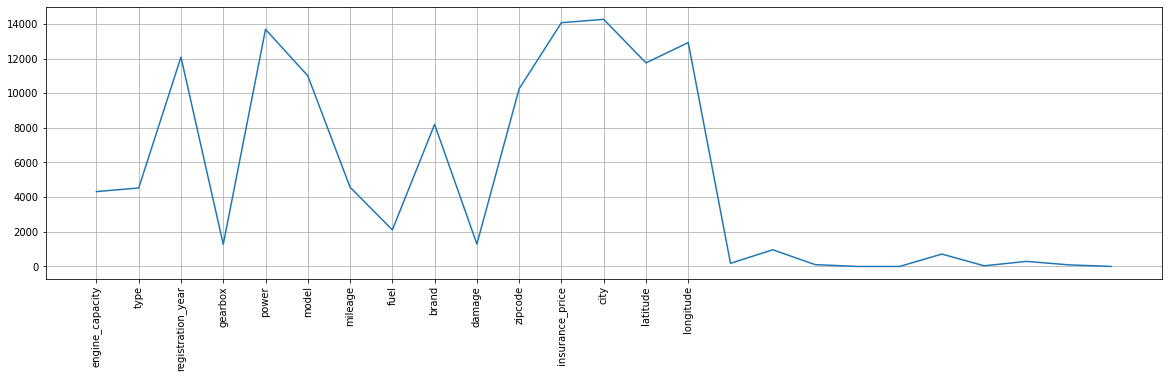

In [6]:
train_features = [
    'engine_capacity', 'type', 'registration_year', 'gearbox',
    'power', 'model', 'mileage', 'fuel', 'brand', 'damage', 'zipcode',
    'insurance_price', 'city', 'latitude', 'longitude'
]

plt.figure(figsize=(20, 5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(train_features)),labels=train_features, rotation='vertical')
plt.grid()